# Lesson - Machine Learning III: Multivariate K-nearest Neighbors

Earlier, we explored how to use a simple k-nearest neighbors machine learning model that used just one feature, or attribute, of the listing to predict the rent price. We first relied on the accommodates column, which describes the number of people a living space can comfortably accommodate. Then, we switched to the bathrooms column and observed an improvement in accuracy. While these were good features to become familiar with the basics of machine learning, it's clear that using just a single feature to compare listings doesn't reflect the reality of the market. An apartment that can accommodate 4 guests in a popular part of Washington D.C. will rent for much higher than one that can accommodate 4 guests in a crime ridden area.

There are 2 ways we can tweak the model to try to improve the accuracy (decrease the RMSE during validation):

- increase the number of attributes (features) the model uses to calculate similarity when ranking the closest neighbors
- increase k, the number of nearby neighbors the model uses when computing the prediction

we'll focus on increasing the number of attributes the model uses. When selecting more attributes to use in the model, we need to watch out for columns that don't work well with the distance equation. This includes columns containing:

non-numerical values (e.g. city or state)
- Euclidean distance equation expects numerical values
missing values
- distance equation expects a value for each observation and attribute
non-ordinal values (e.g. latitude or longitude)
- ranking by Euclidean distance doesn't make sense if all attributes aren't ordinal

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Setting pandas display options for large data
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

In [2]:
# Read the dataset and clean the price columns
dc_listings = pd.read_csv('dc_airbnb.csv')
dc_listings = dc_listings.loc[np.random.permutation(len(dc_listings))] # Note: Rerunning the Kernel will change 
# training and test datasets and results will always be different due to this line of code
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
dc_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3723 entries, 2678 to 2307
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_rate    3289 non-null   object 
 1   host_acceptance_rate  3109 non-null   object 
 2   host_listings_count   3723 non-null   int64  
 3   accommodates          3723 non-null   int64  
 4   room_type             3723 non-null   object 
 5   bedrooms              3702 non-null   float64
 6   bathrooms             3696 non-null   float64
 7   beds                  3712 non-null   float64
 8   price                 3723 non-null   float64
 9   cleaning_fee          2335 non-null   object 
 10  security_deposit      1426 non-null   object 
 11  minimum_nights        3723 non-null   int64  
 12  maximum_nights        3723 non-null   int64  
 13  number_of_reviews     3723 non-null   int64  
 14  latitude              3723 non-null   float64
 15  longitude         

### Removing Features

The following columns contain non-numerical values:

`room_type`: e.g. Private room
`city`: e.g. Washington
`state`: e.g. DC
while these columns contain numerical but non-ordinal values:

`latitude`: e.g. 38.913458
`longitude`: e.g. -77.031
`zipcode`: e.g. 20009

While we could convert the `host_response_rate` and `host_acceptance_rate` columns to be numerical (right now they're object data types and contain the % sign), these columns describe the host and not the living space itself. Since a host could have many living spaces and we don't have enough information to uniquely group living spaces to the hosts themselves, we'll avoid using any columns that don't directly describe the living space or the listing itself:

`host_response_rate`
`host_acceptance_rate`
`host_listings_count`
Let's remove these 9 columns from the Dataframe.

In [3]:
columns = ['room_type', 'city', 'state', 'latitude', 'longitude', 'zipcode', 
           'host_response_rate', 'host_acceptance_rate', 'host_listings_count']
dc_listings = dc_listings.drop(columns = columns)
dc_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3723 entries, 2678 to 2307
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       3723 non-null   int64  
 1   bedrooms           3702 non-null   float64
 2   bathrooms          3696 non-null   float64
 3   beds               3712 non-null   float64
 4   price              3723 non-null   float64
 5   cleaning_fee       2335 non-null   object 
 6   security_deposit   1426 non-null   object 
 7   minimum_nights     3723 non-null   int64  
 8   maximum_nights     3723 non-null   int64  
 9   number_of_reviews  3723 non-null   int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 319.9+ KB


### Missing Values

Of the remaining columns, 3 columns have a few missing values (less than 1% of the total number of rows):

`bedrooms`
`bathrooms`
`beds`
Since the number of rows containing missing values for one of these 3 columns is low, we can select and remove those rows without losing much information. There are also 2 columns that have a large number of missing values:

`cleaning_fee` - 37.3% of the rows
`security_deposit` - 61.7% of the rows
and we can't handle these easily. We can't just remove the rows containing missing values for these 2 columns because we'd miss out on the majority of the observations in the dataset. Instead, we'll remove these 2 columns entirely from consideration.

In [4]:
dc_listings = dc_listings.drop(columns = ['cleaning_fee', 'security_deposit'])
dc_listings = dc_listings.dropna(axis = 0)
dc_listings = dc_listings.reset_index(drop = True)

In [5]:
dc_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3671 entries, 0 to 3670
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       3671 non-null   int64  
 1   bedrooms           3671 non-null   float64
 2   bathrooms          3671 non-null   float64
 3   beds               3671 non-null   float64
 4   price              3671 non-null   float64
 5   minimum_nights     3671 non-null   int64  
 6   maximum_nights     3671 non-null   int64  
 7   number_of_reviews  3671 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 229.6 KB


In [6]:
dc_listings.head()

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
0,8,2.0,1.0,4.0,130.0,2,30,25
1,5,0.0,1.0,4.0,110.0,2,400,1
2,4,1.0,1.0,1.0,105.0,3,365,76
3,1,1.0,2.5,1.0,32.0,4,365,1
4,4,1.0,1.0,2.0,89.0,2,1125,18


### Normalize Columns

The `accommodates`, `bedrooms`, `bathrooms`, `beds`, and `minimum_nights` columns hover between 0 and 12 (at least in the first few rows), the values in the maximum_nights and number_of_reviews columns span much larger ranges. For example, the maximum_nights column has values as low as 4 and as high as 1125, in the first few rows itself. If we use these 2 columns as part of a k-nearest neighbors model, these attributes could end up having an outsized effect on the distance calculations, because of the largeness of the values.

For example, 2 living spaces could be identical across every attribute but be vastly different just on the maximum_nights column. If one listing had a maximum_nights value of 1825 and the other a maximum_nights value of 4, because of the way Euclidean distance is calculated, these listings would be considered very far apart because of the outsized effect the largeness of the values had on the overall Euclidean distance. To prevent any single column from having too much of an impact on the distance, we can normalize all of the columns to have a mean of 0 and a standard deviation of 1.

Normalizing the values in each column to the standard normal distribution (mean of 0, standard deviation of 1) preserves the distribution of the values in each column while aligning the scales. To normalize the values in a column to the standard normal distribution, we need to:

The mathematical formula describing the transformation that needs to be applied for all values in a column is given by:

$$x=\frac{x-\mu}{\sigma}$$
where x is a value in a specific column, μ is the mean of all the values in the column, and σ is the standard deviation of all the values in the column.

Below, we will perform this normalization using the pandas `pd.mean()` and `pd.std()` functions. These methods were written with mass column transformation in mind and when we call `mean()` or `std()`, the appropriate column means and column standard deviations are used for each value in the Dataframe. We will also add original `price` column to the new dataframe `normalized_listings` in order to avoid the price column being normalized..

In [7]:
normalized_listings = (dc_listings - dc_listings.mean()) / (dc_listings.std())
normalized_listings['price'] = dc_listings['price']
print(normalized_listings[0:3])


   accommodates  bedrooms  bathrooms      beds  price  minimum_nights  \
0      2.397185  0.939875  -0.439151  1.985752  130.0       -0.065038   
1      0.900320 -1.438810  -0.439151  1.985752  110.0       -0.065038   
2      0.401366 -0.249467  -0.439151 -0.546858  105.0        0.211298   

   maximum_nights  number_of_reviews  
0       -0.016603           0.338385  
1       -0.016593          -0.482505  
2       -0.016594           2.082776  


### Euclidean Distance for Multivariate Cases
We will now train a model that uses two attributes `accommodates` and `bathrooms` when determining how similar 2 living spaces are. Let's refer to the Euclidean distance equation again to see what the distance calculation using 2 attributes would look like:
$$d = \sqrt{(q_1-p_1)^2 + (q_2-p_2)^2 + \cdots + (q_n-p_n)^2}$$
Since we're using 2 attributes, the distance calculation would look like:
$$d = \sqrt{(accommodates_1-accommodates_2)^2 + (bathrooms_1-bathrooms_2)^2 }$$
To find the distance between 2 living spaces, we need to calculate the squared difference between both accommodates values, the squared difference between both bathrooms values, add them together, and then take the square root of the resulting sum. Here's what the Euclidean distance between the first 2 rows in normalized_listings looks like:
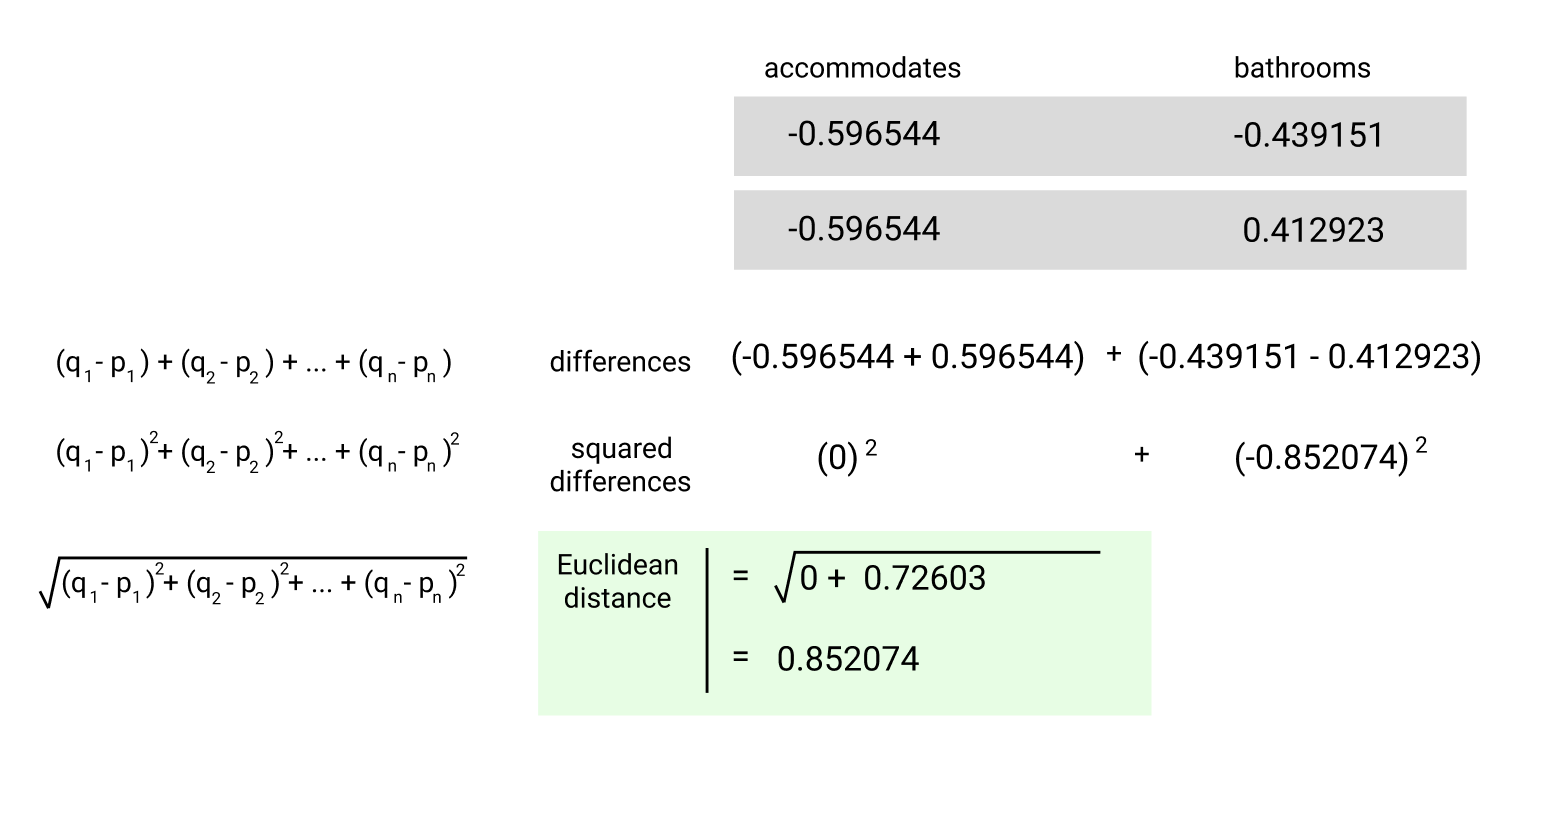

So far, we've been calculating Euclidean distance ourselves by writing the logic for the equation ourselves. We can instead use the `distance.euclidean()` [function](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.euclidean.html) from `scipy.spatial`, which takes in 2 vectors as the parameters and calculates the Euclidean distance between them. The euclidean() function expects:
- both of the vectors to be represented using a list-like object (Python list, NumPy array, or pandas Series)
- both of the vectors must be 1-dimensional and have the same number of elements

```
from scipy.spatial import distance
first_listing = [-0.596544, -0.439151]
second_listing = [-0.596544, 0.412923]
dist = distance.euclidean(first_listing, second_listing)
```

**Practice Exercise**

Calculate the Euclidean distance using only the `accommodates` and `bathrooms` features between the first row and fifth row in normalized_listings using the `distance.euclidean()` function.
Assign the distance value to `first_fifth_distance` and display using the `print` function.

In [8]:
from scipy.spatial import distance
first = normalized_listings.iloc[0][['accommodates','bathrooms']]
fifth = normalized_listings.iloc[4][['accommodates','bathrooms']]
first_fifth_distance = distance.euclidean(first, fifth)
first_fifth_distance

1.9958191063533608

### Scikit Learn
So far, we've been writing functions from scratch to train the k-nearest neighbor models. While this is helpful deliberate practice to understand how the mechanics work, we can be more productive and iterate quicker by using the [scikit-learn library](https://scikit-learn.org/stable/), which is the most popular machine learning library in Python. Scikit-learn contains functions for all of the major machine learning algorithms and a simple, unified workflow. Both of these properties allow data scientists to be incredibly productive when training and testing different models on a new dataset.

The scikit-learn workflow consists of 4 main steps:

- instantiate the specific machine learning model (as an object) we want to use (from the relevant class) 
- fit the model to the training data
- use the model to make predictions
- evaluate the accuracy of the predictions

Each model in scikit-learn is implemented as a separate class and the first step is to identify the class we want to create an instance of. In our case, we want to use the `KNeighborsRegressor` [class](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.fit).Any model that helps us predict numerical values, like listing price in our case, is known as a regression model. The other main class of machine learning models is called classification, where we're trying to predict a label from a fixed set of labels (e.g. blood type or gender). The word regressor from the class name KNeighborsRegressor refers to the regression model class that we just discussed.

Scikit-learn uses a similar object-oriented style to Matplotlib and we need to instantiate an empty model first by calling the constructor:

In [9]:
# instatinate a model as an object of the class
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(algorithm = 'brute')

If we refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor), we'll notice that by default:

- n_neighbors: the number of neighbors, is set to 5
- algorithm: for computing nearest neighbors, is set to auto
- p: set to 2, corresponding to Euclidean distance

We will set the algorithm parameter to `brute` and leave the `n_neighbors` value as 5, which matches the implementation we are working on. If we leave the algorithm parameter set to the default value of `auto`, scikit-learn will try to use tree-based optimizations to improve performance.

### Fitting the Model and making Predictions

Now, we will fit the model to the data using the `fit` [method](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.fit). For all models, the fit method takes in 2 required parameters:
- matrix-like object, containing the feature columns we want to use from the training set.
- list-like object, containing correct target values.

Matrix-like object means that the method is flexible in the input and either a Dataframe or a NumPy 2D array of values is accepted. This means we can select the columns you want to use from the Dataframe and use that as the first parameter to the fit method.

All of the following are acceptable list-like objects:

- NumPy array
- Python list
- pandas Series object (e.g. when selecting a column)

We can select the target column from the Dataframe, `price` in our case, and use that as the second parameter to the fit method:

In [10]:
# fit the training data
train_df = normalized_listings.iloc[0:2792]
test_df = normalized_listings.iloc[2792:]
# Matrix-like object, containing just the 2 columns of interest from training set.
train_features = train_df[['accommodates', 'bathrooms']]
# List-like object, containing just the target column, `price`.
train_target = train_df['price']
# Pass everything into the fit method.
knn.fit(train_features, train_target)

KNeighborsRegressor(algorithm='brute')

When the `fit()` method is called, scikit-learn stores the training data we specified within the KNearestNeighbors instance (`knn`). If we try passing in data containing missing values or non-numerical values into the `fit` method, scikit-learn will return an error. Scikit-learn contains many such features that help prevent us from making common mistakes.

After specifying the training data we want used to make predictions, we can use the `predict` [method](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.predict) to make predictions on the test set. The `predict` method has only one required parameter:
- matrix-like object, containing the feature columns from the dataset we want to make predictions on:

The number of feature columns we use during both training and testing need to match or scikit-learn will return an error.
The `predict(`) method returns a NumPy array containing the predicted `price` values for the test set.

In [11]:
# make predictions on test data
predictions = knn.predict(test_df[['accommodates', 'bathrooms']])

### Calculating Mean Square Error (MSE)
Earlier, we calculated the MSE and RMSE values using the pandas arithmetic operators to compare each predicted value with the actual value from the price column of our test set. Alternatively, we can instead use the `sklearn.metrics.mean_squared_error` [function()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error). 
The mean_squared_error() function takes in 2 inputs:

- list-like object, representing the true values
- list-like object, representing the predicted values using the model

In [12]:
from sklearn.metrics import mean_squared_error

y_true = test_df['price']
y_pred = predictions
two_features_mse = mean_squared_error(y_true, y_pred) # calculate mse
two_features_rmse = two_features_mse **(1/2) # calculate rmse
print(two_features_mse)
print(two_features_rmse)


17403.557406143347
131.92254320677475


### Model Results for Four Features

We will calculate model results for four features i.e. 'accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews' using sklearn with:
n_neighbors = 5 (default); and
algorithm = 'brute'

In [13]:
# For accommodates feature
# instatinate a model as an object of the class
from sklearn.neighbors import KNeighborsRegressor
knn_four = KNeighborsRegressor(algorithm = 'brute')
# fit the training data

# Matrix-like object, containing just the 4 columns of interest from training set.
train_four_features = train_df[['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']]
# List-like object, containing just the target column, `price`.
train_four_target = train_df['price']
# Pass everything into the fit method.
knn_four.fit(train_four_features, train_four_target)

# make predictions on test data
four_predictions = knn_four.predict(test_df[['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']])
# Calculate RMSE
from sklearn.metrics import mean_squared_error

y_four_true = test_df['price']
y_four_pred = four_predictions
four_mse = mean_squared_error(y_four_true, y_four_pred) # calculate mse
four_rmse = four_mse **(1/2) # calculate rmse
print(four_mse)
print(four_rmse)

16186.145210466439
127.22478221819222


# Model Results for all Features
We will calculate model results for all features i.e. 'accommodates', 'bedrooms', 'bathrooms', 'beds','number_of_reviews', 'minimum_nights', 'maximum_nights', using sklearn with:
n_neighbors = 5 (default); and
algorithm = 'brute'

In [14]:
# instatinate a model as an object of the class
from sklearn.neighbors import KNeighborsRegressor
knn_all = KNeighborsRegressor(algorithm = 'brute')
# fit the training data

# Matrix-like object, containing all columns of interest from training set.
train_all_features = train_df[['accommodates', 'bedrooms', 'bathrooms', 'beds','number_of_reviews', 'minimum_nights', 'maximum_nights']]
# List-like object, containing just the target column, `price`.
train_all_target = train_df['price']
# Pass everything into the fit method.
knn_all.fit(train_all_features, train_all_target)

# make predictions on test data
all_predictions = knn_all.predict(test_df[['accommodates', 'bedrooms', 'bathrooms', 'beds','number_of_reviews', 'minimum_nights', 'maximum_nights']])
# Calculate RMSE
from sklearn.metrics import mean_squared_error

y_all_true = test_df['price']
y_all_pred = all_predictions
all_mse = mean_squared_error(y_all_true, y_all_pred) # calculate mse
all_rmse = all_mse **(1/2) # calculate rmse
print(all_mse)
print(all_rmse)

17762.994084186572
133.27788295207338


In [15]:
# Alternately, above code can be written as under
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')

features = train_df.columns.tolist()
features.remove('price')

knn.fit(train_df[features], train_df['price'])
all_features_predictions = knn.predict(test_df[features])
all_features_mse = mean_squared_error(test_df['price'], all_features_predictions)
all_features_rmse = all_features_mse ** (1/2)
print(all_features_mse)
print(all_features_rmse)

17768.937337883955
133.30017756133694


### Conclusion

Interestingly enough, the RMSE value actually increased to 133.3 when we used all of the features available to us. This means that selecting the right features is important and that using more features doesn't automatically improve prediction accuracy. We should re-phrase the lever we mentioned earlier from:

- increase the number of attributes the model uses to calculate similarity when ranking the closest neighbors
to:

- select the relevant attributes the model uses to calculate similarity when ranking the closest neighbors

The process of selecting features to use in a model is known as **feature selection**.


#### Note: Rerunning the Kernel in this notebook will change the training and test datsets due to the first code cell which randomizes the data. The feature is deliberately kept in the notebook, so as to see the effect of changing the datasets on knn models.